# Esonero 1
L'obiettivo di questo notebook è:

1.Implementare un algoritmo che genera istogrammi basato sui feature descriptors,utilizzando l'algoritmo SURF;

2.Dare in input il set di immagini MNIST all'algoritmo al passo 1. e applicare la regressione logistica (da scikit-learn) ;

3.Applicare la regressione logistica (da scikit-learn) sul set di immagini MNIST;

4.Confrontare i due approcci e trarre delle conclusioni.


# Premessa

Le immagini utilizzate sono state generate tramite il metodo fetch_openml('mnist_784') e salvate in una cartella rinominata dataset, mantendendo la divisione originale.


In [1]:
def createData(x,y):
    for i in range(0,len(x)):
        img=x[i].reshape(28,28)
        cv2.imwrite('./dataset'+'/'+ str(y[i])+'/'+str(i)+'.png',img)

def loadData(x,y):
    load = []
    for i in range(0, len(x)):
        load.append('./dataset' + '/' + str(y[i]) + '/' + str(i) + '.png')
    return load

def preP(train):
    dim = (100, 100)
    esamina=[]
    for img in train:
        img = cv2.imread(img)
        res = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
        gray = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        esamina.append(gray)
    return esamina

In [2]:
from sklearn.datasets import fetch_openml
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

mnist_data = fetch_openml('mnist_784')
x, y = mnist_data['data'][:21000], mnist_data['target'][:21000]
y = y.astype(np.uint8)#converto y 
train=loadData(x,y)
train=preP(train)
print("ok data!")

ok data!


Si utilizza una parte del dataset,composta da 21000 immagini;già preprocessate.
Tuttavia, al fine di ottenere buone features,bisogna assicurare che le immagini siano correttamente lette in scala di grigio e ridimensionate; come accade nella funzione preP().

# Passo 1

Creazione dell'algoritmo:

a)Si estrae un insieme di features da ogni immagine del training set (rappresentazione multidimensionale).

Si utilizza l'algoritmo SURF,con un hessianThreshold=300, o meglio solo le funzioni la cui hessiana è più grande della soglia, sono considerate dal detector;pertanto maggiore è il valore, minori saranno i punti ottenuti. 
E' bene settare l'attributo tra 300 e 500, a seconda del contrasto dell'immagine.
I restanti attributi, rappresentano il nOctaves=24(numero di ottave di una piramide gaussiana utilizzate dal detector;maggiore è il valore maggiori saranno le features) e nOctaveLayers=18(numero di immagini all'interno di ciascuna ottava di una piramide gaussiana).


In [3]:
def vectors(train):
    descriptors = []
    keypoints= []
    conta=0
    for i in range(0,len(train)):
        surf = cv2.xfeatures2d.SURF_create(300,nOctaves=24,nOctaveLayers=18)
        kp, des = surf.detectAndCompute(train[i],None)
        if (str(des) == 'None'):
            descriptors.append(np.zeros(64))
        else:
            descriptors.append(des)
            conta=conta+1
        keypoints.append(kp)
    return descriptors,keypoints,conta

In [4]:
descriptors,keypoints,conta=vectors(train)
print("ok descriptors!")
print("Ho trovato keypoints per "+ str(conta) +" immagini")

ok descriptors!
Ho trovato keypoints per 21000 immagini


L'algoritmo SURF, in questa circostanza, riesce ad identificare dei keypoints e calcolare i relativi descriptors per ogni immagine in esame.Tuttavia, se ciò non fosse possibile, verrà inserita nella lista descriptors un vettore contente ogni valore a 0.

Si mostrano, a titolo di esempio, i keypoints rilevati ad una immagine del dataset.

Ho trovato 31 keypoints per l'immagine selezionata


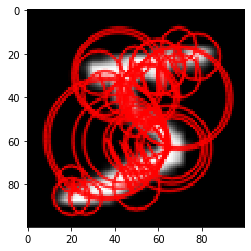

In [5]:
des,kp=descriptors[0],keypoints[0]
img=cv2.drawKeypoints(train[0],kp,None,(255,0,0),4)
plt.imshow(img)
print("Ho trovato "+ str(len(kp))+ " keypoints per l'immagine selezionata")

b)Si trovano i K raggruppamenti di tutte le features utilizzando K-Means, associando ogni feautures al cluster
appropriato.

Prima di applicare il clustering, è necessario modificare la lista dei descriptors, trasformando
l'elenco in un unico blocco da analizzare.

In [6]:
def cleanV(descriptors):
    modificata = np.zeros(64)
    for des in descriptors:
        modificata = np.vstack((modificata, des))
    return modificata[1:]

In [7]:
modificata = cleanV(descriptors)

Si applica ora il l'algoritmo KMeans utilizzando la versione MiniBatch,contenuta nel modulo sklearn, 
opportunamente settata.
Questo approccio genera una soluzione in maniera più rapida e meno costosa, in termini computazionali, rispetto a quello classico; a discapito,però, di un'accuratezza leggermente minore dell'algoritmo.


In [8]:
from sklearn.cluster import MiniBatchKMeans
k=700#numero di cluster(gruppi)
kmeans=MiniBatchKMeans(init='k-means++',init_size=3*k,n_clusters=k,batch_size=k)
pred=kmeans.fit_predict(modificata)
centroids=kmeans.cluster_centers_
print("ok KMeans!")



ok KMeans!


c)Per ogni immagine, si calcola l’istogramma delle features sui K gruppi e ogni feature contribuisce al cluster a cui è associata.


Viene applicato il metodo di scipy cluster.vq.vq(vector quantization)che, ricevendo in ingresso i centroidi calcolati da KMeans,restituisce una rappresentazione delle features in base al centroide più vicino.

Il seguente approccio è una alternativa valida a  quello classico,presentato durante il corso e che calcola la distanza descriptors-centroids, con poco costo computazionale e con una minima implementazione a livello di codice.

Verrà restituito, per ogni immagine, un vettore di lunghezza n pari al numero di descriptors che la compongono;
dove ogni descriptor è codificato con l'indice del centroide che più gli si "avvicina"(centroide con distanza minore dal descriptor in esame).

In [9]:
from scipy.cluster.vq import *
def distanza(descriptors,centroids):
    rap=[]
    for i in range(0, len(descriptors)):
        rappresentazione= vq(descriptors[i], centroids)
        rap.append(rappresentazione[0])
    return rap

In [10]:
rappresentazione=distanza(descriptors,centroids)

Si calcolano ora gli istogrammi che, in virtù delle proprietà elencate al passo precedente, non necessitano di essere normalizzati:

In [11]:
def hist(rappresentazione,k):
    istogrammi = []
    classi = np.arange(k)
    for i in rappresentazione:
        hist, classi = np.histogram(i, bins=classi)#istogramma
        istogrammi.append(np.asarray(hist))
    return istogrammi


In [12]:
istogrammi=hist(rappresentazione,k)


Ecco come appare un istogramma:

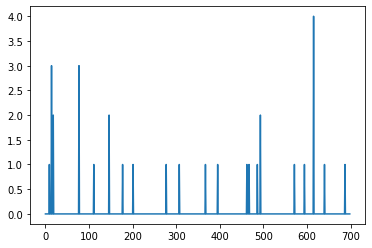

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(istogrammi[0])


# Passo 2 

Si applica la regressione logistica dando in input gli istogrammi creati.

In [14]:
from sklearn.model_selection import train_test_split
hist_train, hist_test, y_train, y_test = train_test_split(istogrammi, y,
                                                        test_size=4000,
                                                        shuffle=True,
                                                        random_state=8735,
                                                        stratify=y)

print(f'Train hist = {len(hist_train)} and y = {len(y_train)}')
print(f'Test  hist = {len(hist_test)} and y = {len(y_test)}')

Train hist = 17000 and y = 17000
Test  hist = 4000 and y = 4000


Si utilizzano 17000 istogrammi per il train set e 4000 per il test set.

Per l'addestramento del modello è stato scelto l'algoritmo di discesa del gradiente impostando una perdita logaritmica.

In [15]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log', random_state=2936)
model.fit(hist_train, y_train)

print('DONE')

DONE


Si valuta l'accuratezza sul train set e su test set:

In [16]:
scoreTraining = model.score(hist_train, y_train)
scoreTest = model.score(hist_test, y_test)

print(f'Training Accuracy:  {scoreTraining:.4f}')
print(f'Test Accuracy:      {scoreTest:.4f}')

Training Accuracy:  0.9414
Test Accuracy:      0.8782


Gli score ottenuti indicano una correttezza sul train test di circa il 94% e sul test set di circa l'88%,un ottimo risultato.
Si crea ora la matrice di confusione per capire meglio come opera il modello e valutare la coerenza degli score precedenti.

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix
y_pred = model.predict(hist_test)
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, columns=range(10)).head(10)

,0,1,2,3,4,5,6,7,8,9
0,370,0,0,0,0,2,16,1,2,7
1,0,443,1,0,6,0,3,3,0,0
2,2,5,317,4,6,7,3,29,11,2
3,0,1,7,370,2,21,2,5,5,2
4,0,0,3,6,363,6,3,7,1,1
5,3,0,2,8,5,316,4,3,1,11
6,9,1,4,2,1,11,311,9,3,42
7,1,7,27,5,14,7,7,345,2,3
8,2,1,9,5,3,3,1,2,352,7
9,7,5,2,2,6,13,35,2,8,326


Nella matrice le righe i rappresentano le classi reali, le colonne j le classi predette;la cella (i,j) rappresenta un'istanza della classe reale che è stata etichettata con la classe predetta.La diagonale principale contiene le etichette corrette.Si ottiene una matrice che contiene la maggior parte dei valori sulla diagonale principale,un risultato ottimo,a conferma dell'andamento degli score precedenti.

Un'informazione qualitativa sul comportamento del modello, in maniera puntuale, è ottenuta dai rate di precision e recall,tramite la metodologia one vs rest, generando una tabella per ogni classe presente.
Gli esempi positivi saranno quelli della classe target, tutti gli altri saranno negativi.

In [18]:
# multiclass TP and FP rate
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

for idx_class in range(10):
    confusion_matrix = mcm[idx_class, ...]
    
    print(f'\n\nCLASS {idx_class}')
    # true label on row, prediction on column
    print(pd.DataFrame(confusion_matrix, columns=['False', 'True'], index=['False', 'True']))



CLASS 0
       False  True
False   3578    24
True      28   370


CLASS 1
       False  True
False   3524    20
True      13   443


CLASS 2
       False  True
False   3559    55
True      69   317


CLASS 3
       False  True
False   3553    32
True      45   370


CLASS 4
       False  True
False   3567    43
True      27   363


CLASS 5
       False  True
False   3577    70
True      37   316


CLASS 6
       False  True
False   3533    74
True      82   311


CLASS 7
       False  True
False   3521    61
True      73   345


CLASS 8
       False  True
False   3582    33
True      33   352


CLASS 9
       False  True
False   3519    75
True      80   326


Analizzando, ad esempio, la classe 0,si ottiene che 370 record sono stati correttamente classificati, ottendo 24 falsi positivi e 28 falsi negativi(immagini che rappresentavano il numero 0 ma che il modello ha predetto in maniera diversa).La classe che si comporta meglio è la 1 con 443 identificazioni corrette,20 falsi positivi e 13 falsi negativi;quella "peggiore" se così si può definire, è la numero 6.

Si analizzano ora gli score di precision,recall,f1-score(media armonica tra i due valori precedenti) ,per visualizzare ancore meglio il comportamento di ogni classe.

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       398
           1       0.96      0.97      0.96       456
           2       0.85      0.82      0.84       386
           3       0.92      0.89      0.91       415
           4       0.89      0.93      0.91       390
           5       0.82      0.90      0.86       353
           6       0.81      0.79      0.80       393
           7       0.85      0.83      0.84       418
           8       0.91      0.91      0.91       385
           9       0.81      0.80      0.81       406

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



La classe che si comporta in modo peggiore,in termini di recall, è la 6 che predice correttamente solo il 79% degli esempi con una precision del 81%, per quella classe.La migliore è la classe 1, con 97% di esempi correttamente predetti con una precision del 96%. Le altre classi, presentano valori abbastanza buoni. Si può concludere che l'accuratezza del modello è  dell'88%, un ottimo risultato!

# Passo 3

Si effettua ora la regressione logistica sul set di immagini, prendendone 21000,formando un train test di 17000 immagini ed un test set di 4000.

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=4000,
                                                   shuffle=True,
                                                   random_state=8735,
                                                   stratify=y)

print(f'Train x = {x_train.shape} and y = {y_train.shape}')
print(f'Test  x = {x_test.shape} and y = {y_test.shape}')

Train x = (17000, 784) and y = (17000,)
Test  x = (4000, 784) and y = (4000,)


In [21]:
# Train the model
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log', random_state=2936)
model.fit(x_train, y_train)

print('DONE')

DONE


In [22]:
# evaluate training performance as global accuracy

scoreTraining = model.score(x_train, y_train)
scoreTest = model.score(x_test, y_test)

print(f'Training Accuracy:  {scoreTraining:.4f}')
print(f'Test Accuracy:      {scoreTest:.4f}')


Training Accuracy:  0.8937
Test Accuracy:      0.8558


Il modello sembra ottimo,tuttavia con score inferiori rispetto a quello precedente.Si procede con un'analisi più dettagliata:

In [23]:
import pandas as pd
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, columns=range(10)).head(10)

,0,1,2,3,4,5,6,7,8,9
0,372,0,1,1,0,11,1,2,8,2
1,0,431,3,2,1,8,0,2,7,2
2,2,5,328,7,5,20,6,3,10,0
3,0,3,12,333,2,44,0,9,3,9
4,0,2,4,0,335,9,7,1,4,28
5,1,0,4,6,2,326,0,2,4,8
6,5,1,8,0,3,38,333,0,4,1
7,1,2,3,1,3,2,0,385,3,18
8,3,9,5,11,7,118,3,0,217,12
9,3,5,1,3,6,16,1,8,0,363


La matrice di confusione presenta la maggior parte dei valori sulla diagonale principale ma si evince che il modello ha difficoltà con l'identificazione della classe 5.Analizzando più nel dettaglio:

In [24]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

for idx_class in range(10):
    confusion_matrix = mcm[idx_class, ...]
    
    print(f'\n\nCLASS {idx_class}')
    # true label on row, prediction on column
    print(pd.DataFrame(confusion_matrix, columns=['False', 'True'], index=['False', 'True']))



CLASS 0
       False  True
False   3587    15
True      26   372


CLASS 1
       False  True
False   3517    27
True      25   431


CLASS 2
       False  True
False   3573    41
True      58   328


CLASS 3
       False  True
False   3554    31
True      82   333


CLASS 4
       False  True
False   3581    29
True      55   335


CLASS 5
       False  True
False   3381   266
True      27   326


CLASS 6
       False  True
False   3589    18
True      60   333


CLASS 7
       False  True
False   3555    27
True      33   385


CLASS 8
       False  True
False   3572    43
True     168   217


CLASS 9
       False  True
False   3514    80
True      43   363


La classe 5 presenta troppi falsi positivi che condizionano la bontà del modello.

In [25]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       398
           1       0.94      0.95      0.94       456
           2       0.89      0.85      0.87       386
           3       0.91      0.80      0.85       415
           4       0.92      0.86      0.89       390
           5       0.55      0.92      0.69       353
           6       0.95      0.85      0.90       393
           7       0.93      0.92      0.93       418
           8       0.83      0.56      0.67       385
           9       0.82      0.89      0.86       406

    accuracy                           0.86      4000
   macro avg       0.87      0.85      0.85      4000
weighted avg       0.88      0.86      0.86      4000



Questi score, confermano l'influenza negativa della classe 5 sulla bontà del modello, caratterizzata da una precision di solo il 55% e mettono in luce l'influenza negativa anche da parte della classe 8, che presenta una recall di solo il 56%.
Infatti, i valori di f1 score per queste due classi, sono rispettivamente del 69% e del 67%, troppo bassi!

# Passo 4

Si conclude, alla luce dei risultati ottenuti, che la regressione logistica applicata alla flattenizzazione delle immagini, si comporta in maniera migliore rispetto ad un approccio tradizionale.

Emilio Casella matr.204898